In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
import tensorflow as tf

In [0]:
from google.colab import files
uploaded = files.upload()

Saving english.txt to english.txt


In [0]:
from google.colab import files
uploaded = files.upload()

Saving french.txt to french.txt


In [0]:
file = open('english.txt').read()
target_sentences=file.split('\n')

In [0]:
len(target_sentences)

137861

In [0]:
target_sentences[5]

'his favorite fruit is the orange , but my favorite is the grape .'

In [0]:
file= open("french.txt").read()
source_sentences=file.split("\n")

In [0]:
french_sentence[5]

"son fruit préféré est l'orange , mais mon préféré est le raisin ."

In [0]:
len(french_sentence)

137861

## **VOCABULARY :**

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
def preprocess_sentence(sentence):
  
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)

    sentence = sentence.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [0]:
def create_dataset(text):
  language = [preprocess_sentence(sentence) for sentence in text] 
  return language
input_language=create_dataset(source_sentences)
target_language=create_dataset(target_sentences) 

In [0]:
input_language[2]

'<start> california est g n ralement calme en mars , et il est g n ralement chaud en juin . <end>'

In [0]:
def tokenization(text):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(text)
  word_vectors = tokenizer.texts_to_sequences(text)
  word_vectors = pad_sequences(word_vectors,padding='post',maxlen=27)
  return word_vectors,tokenizer

In [0]:
def load_dataset(french_language,english_language):
    input_tensor, inp_lang_tokenizer = tokenization(french_language)
    target_tensor, targ_lang_tokenizer = tokenization(english_language)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer
input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer=load_dataset(input_language,target_language)

In [0]:
target_tensor.shape[0]

137861

In [0]:
len(input_tensor[0])

27

In [0]:
from sklearn.model_selection import train_test_split
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(110288, 110288, 27573, 27573)

In [0]:
from tensorflow.python.keras.models import Model,Sequential
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding,RepeatVector
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
input_tensor.shape[1]

27

## **Building an Encoder**

In [0]:
in_timesteps=input_tensor.shape[1]
out_timesteps=target_tensor.shape[1]
units = 512
in_vocab = len( inp_lang_tokenizer.word_index)+1
out_vocab = len( targ_lang_tokenizer.word_index)+1


In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      embedding_vecor_length = 32
      model = Sequential()
      model.add(Embedding(in_vocab,embedding_vecor_length,input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
# model compilation
model = define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units)


In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 27, 32)            10432     
_________________________________________________________________
lstm_4 (LSTM)                (None, 512)               1116160   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 27, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 27, 512)           2099200   
_________________________________________________________________
dense_2 (Dense)              (None, 27, 203)           104139    
Total params: 3,329,931
Trainable params: 3,329,931
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(lr=0.0001)
model.compile(opt, loss='sparse_categorical_crossentropy')



In [0]:
# train model
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, save_best_only=True, mode='min'
                                                 )
history = model.fit(input_tensor_train, target_tensor_train,
                    epochs=30, batch_size=64, validation_split = 0.2,callbacks=[cp_callback],
                    verbose=1
                    )


Train on 88230 samples, validate on 22058 samples
Epoch 1/30
88192/88230 [============================>.] - ETA: 0s - loss: 1.4780
Epoch 00001: val_loss improved from inf to 0.89677, saving model to training_1/cp.ckpt
88230/88230 [==============================] - 161s 2ms/sample - loss: 1.4778 - val_loss: 0.8968
Epoch 2/30
88192/88230 [============================>.] - ETA: 0s - loss: 0.7625
Epoch 00002: val_loss improved from 0.89677 to 0.64524, saving model to training_1/cp.ckpt
88230/88230 [==============================] - 158s 2ms/sample - loss: 0.7624 - val_loss: 0.6452
Epoch 3/30
88192/88230 [============================>.] - ETA: 0s - loss: 0.6003
Epoch 00003: val_loss improved from 0.64524 to 0.52914, saving model to training_1/cp.ckpt
88230/88230 [==============================] - 158s 2ms/sample - loss: 0.6003 - val_loss: 0.5291
Epoch 4/30
88192/88230 [============================>.] - ETA: 0s - loss: 0.5241
Epoch 00004: val_loss improved from 0.52914 to 0.47228, saving mod

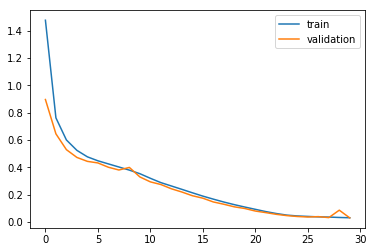

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [0]:
scores = model.evaluate(input_tensor_val,target_tensor_val, verbose=0)

In [0]:
preds = model.predict_classes(input_tensor_val)

In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j],targ_lang_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], targ_lang_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else:
        temp.append(t)
  preds_text.append(' '.join(temp))

In [0]:
len( actual_text)

27573

In [0]:
target_tensor_val[0]

array([  2,  29,  71,  97, 113, 115, 103,   3,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [0]:
actual_text = []
for i in target_tensor_val:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j],targ_lang_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], targ_lang_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else:
        temp.append(t)
  actual_text.append(' '.join(temp))

In [0]:
df = pd.DataFrame({'actual_sentence':actual_text,'predicted_sentence' : preds_text})

In [0]:
df.head(5)

,actual_sentence,predicted_sentence
0,start she dislikes that old red truck end ...,start she dislikes that old red truck end ...
1,start california is relaxing during autumn but...,start california is relaxing during fall but i...
2,start india is sometimes warm during july and ...,start india is sometimes warm during july and ...
3,start mice were my favorite animals end ...,start were my favorite animals end ...
4,start france is sometimes wet during spring bu...,start france is sometimes wet during spring bu...


In [0]:
count=0
index=[]
for i in range(len(actual_text)-1):
  if actual_text[i] != preds_text[i]:
    count += 1
    index.append(i)
    
  i += 1
    

In [0]:
count

8041

In [0]:
index[:10]

[1, 3, 5, 10, 14, 16, 18, 19, 22, 24]

In [0]:
actual_text[22]

'start france is sometimes wet during autumn and it is never pleasant in november end            '

In [0]:
preds_text[22]

'start france is sometimes wet during autumn and it is never nice in november end            '